# Hyper-Scale Machine Learning with MinIO and TensorFlow

We are living in a transformative era defined by information and AI. Massive amounts of data are generated and collected every day to feed these voracious, state-of-the-art, AI/ML algorithms. The more data, the better the outcomes.

One of the frameworks that has emerged as the lead industry standards is [Google's TensorFlow](https://www.tensorflow.org/).  Highly versatile, one can get started quickly and write simple models with their [Keras](https://www.tensorflow.org/guide/keras?hl=en) framework. If you seek a more advanced approach TensorFlow also allows you to construct your own machine learning models using low level APIs. No matter what strategy you choose, TensorFlow will make sure that your algorithm gets optimized for whatever infrastructure you select for your algorithms - whether it's [CPU's](https://en.wikipedia.org/wiki/Central_processing_unit), [GPU's](https://en.wikipedia.org/wiki/Graphics_processing_unit) or [TPU's](https://en.wikipedia.org/wiki/Tensor_processing_unit).

As datasets become too large to fit into memory or local disk, AI/ML pipelines now have the requirement to load data from an external data source. Take for example the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) dataset with its `14 Million` Images with an estimated storage size of `1.31TB`. This dataset cannot be fit into memory nor on any machine local storage drive. These challenges are further complicated if your pipelines are running inside a stateless environment such a Kubernetes (which is increasingly the norm). 

The emerging standard for this problem is to employ high performance object storage in the design of your AI/ML pipelines. MinIO is the leader in this space and has published a number of benchmarks that speak to its throughput capabilities. In this post, we will cover how to leverage MinIO for your TensorFlow projects.

## A Five Stage Hyper-Scale Data Pipeline

To build a hyper-scale pipeline we will have each stage of the pipeline read from MinIO. In this example we are going to build four stages of a machine learning pipeline. This architecture will load the desired data on-demand from MinIO. 

First, we are going to preprocess our dataset and encode it in a format that TensorFlow can quickly digest. This format is the [tf.TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord), which is a type of binary encoding for our data. We are taking this step because we do not want to waste time processing the data during the training as we are planning on loading each batch of training directly from MinIO as it's needed. If the data is pre-processed before we feed it into the model training we save a significant amount of time. Ideally, we create pre-processed chunks of data that group a good chunk of records - at least `100-200MB` in size.

To speed up the data-loading and training stages we are going to leverage the excellent [tf.data](https://www.tensorflow.org/api_docs/python/tf/data) api. This API is designed to efficiently load data during the training/validation of our model. It prepares the next batch of data as the current one is being processed by the model. The advantage of this approach is that it ensures efficient utilization of expensive GPUs or TPUs which cannot sit idle due to slow loading data. MinIO does not encounter this problem - [it can saturate 100Gbps network with a few NVMe drives](https://min.io/resources/docs/MinIO-Throughput-Benchmarks-on-NVMe-SSD-32-Node.pdf) or also with [Hard Disk Drives](https://min.io/resources/docs/MinIO-Throughput-Benchmarks-on-HDD-24-Node.pdf) ensuring the pipeline is crunching data as fast as the hardware allows

During training we want to make sure we store the training checkpoints of our model as well as TensorBoard histograms. The checkpoints are useful in case the training gets interrupted and we want to resume the training or if we get more data and want to keep training our model with the new data and the TensorBoard histograms let us see how the training is going as it happens. TensorFlow supports writing both of these directly to MinIO.

A quick side note. When the model is complete we will save it to MinIO as well - allowing us to serve it using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

![title](pic1.png)

## Building the Pipeline

For our hyper-scale pipeline we are going to use a dataset that can easily fit into your local computer so you can follow along. The [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) from Stanford is great since it has a large number of samples (25,000 for training and 25,000 for testing) so we are going to build a [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) model that will tell us whether a movie review is `positive` or `negative`. Keep in mind that each step can be applied to any larger dataset. The advantage of this dataset is that you can try on your own computer. Let's get started!

We are going to use the [minio client cli tool](https://docs.min.io/docs/minio-client-quickstart-guide.html), also known as `mc` and refer to our MinIO instance as the `myminio` alias. You can download it at [MinIO's Website](https://min.io/download#/linux).

Let's configure our `mc`

In [152]:
!mc config host add myminio http://{minio_address} {minio_access_key} {minio_secret_key}

Added `myminio` successfully.


Create our bucket if it doesn't exist already, alternative you can create it using the [MinIO Console](https://docs.min.io/minio/baremetal/console/minio-console.html)

Download the dataset and upload it to MinIO using [MinIO Client](https://docs.min.io/docs/minio-client-quickstart-guide.html)

In [150]:
!curl -s http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz | mc pipe myminio/{datasets_bucket}/aclImdb_v1.tar.gz

Let's start by declaring some configurations for our pipeline,  such as `batch size`, location of our dataset and a fixed `random seed` so we can run this pipeline again and again and get the same results.

In [8]:
import tensorflow as tf
import tensorflow_io
from minio import Minio
from minio.error import S3Error
import tarfile
import os
import random

In [9]:
print(tf.__version__)

2.2.0


In [10]:
random_seed = 44
batch_size = 128
datasets_bucket = "datasets"
preprocessed_data_folder = "preprocessed-data"
tf_record_file_size = 500
# How to access MinIO
# minio_address = "localhost:9000"
# TODO: REMOVE ME, THIS IS MY LOCAL ENV :-)
minio_address = "192.168.86.197:9000"
minio_access_key = "minioadmin"
minio_secret_key = "minioadmin"

We are going to download our dataset from MinIO using [minio-py](https://github.com/minio/minio-py)

In [11]:
minioClient = Minio(minio_address,
                  access_key=minio_access_key,
                  secret_key=minio_secret_key,
                  secure=False)

In [12]:
try:
       minioClient.fget_object(
           datasets_bucket,
           "aclImdb_v1.tar.gz",
           "/tmp/dataset.tar.gz")
except S3Error as err:
       print(err)

Now let's uncompress the dataset to a temporary folder (`/tmp/dataset`) to preprocess our data

In [13]:
extract_folder = f"/tmp/{datasets_bucket}/"

with tarfile.open("/tmp/dataset.tar.gz", "r:gz") as tar:
    tar.extractall(path=extract_folder)

## Pre-Processing

Due to the structure of the dataset we are going to read from four folders, initially `test` and `train` which hold `25,000` examples each, then, in each of those folders we have `12,500` of each label pos for positive comments and neg for negative comments. From these four folders, we are going to store all samples into two variables, `train` and `test`. If we were preprocessing a dataset that couldn't fit in the local machine we could simply load segments of the object, one at a time and process them as well.

In [14]:
train = []
test = []

dirs_to_read = [
    "aclImdb/train/pos",
    "aclImdb/train/neg",
    "aclImdb/test/pos",
    "aclImdb/test/neg",
]

for dir_name in dirs_to_read:
    parts = dir_name.split("/")
    dataset = parts[1]
    label = parts[2]
    for filename in os.listdir(os.path.join(extract_folder,dir_name)):
        with open(os.path.join(extract_folder,dir_name,filename),"r") as f:
            content = f.read()
            if dataset == "train":
                train.append({
                    "text":content,
                    "label":label
                })
            elif dataset == "test":
                test.append({
                    "text":content,
                    "label":label
                })

We will then shuffle the dataset so we don't introduce bias into the training by providing 12,500 consecutive positive examples followed by 12,500 consecutive negative examples. Our model would have a hard time generalizing that. By shuffling the data the model will get to see and learn from both positive and negative examples at the same time.

In [15]:
random.Random(random_seed).shuffle(train)
random.Random(random_seed).shuffle(test)

Since we are dealing with text we need to turn the text to a vector representation that accurately depicts the meanings of the sentence. If we were dealing with images we would resize the images and turn them into vector representations having each pixel be a value of the resized image. 

For text, however, we have a bigger challenge since a word doesn't really have a numerical representation. This is where [embeddings](https://en.wikipedia.org/wiki/Embedding) are useful. An embedding is a vector representation of some text, in this case we are going to represent the whole review as a single vector of 512 dimensions. Instead of doing the pre-processing of text manually (tokenizing, building vocabulary and training an embeddings layer) we are going to leverage an existing model called [USE (Universal Sentence Encoder)](https://arxiv.org/abs/1803.11175) to encode sentences into vectors so we can continue with our example. This is one of the wonders of deep learning, the ability to re-use different models alongside yours. Here we use TensorFlow Hub and we are going to load the latest `USE` model.

Since we are going to be using this model often, we'll download the model and store it in our `datasets` bucket and use it from there whenever we need it, avoiding a download from the internet every time we run this pipeline.

In [16]:
!curl -s https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz | mc pipe myminio/{datasets_bucket}/models/universal-sentence-encoder_4.tar.gz

Now download the data and load it as a model

In [17]:
try:
    minioClient.fget_object(
        datasets_bucket,
        "models/universal-sentence-encoder_4.tar.gz",
        "/tmp/universal-sentence-encoder_4.tar.gz")
except S3Error as err:
    print(err)

In [18]:
se_model_prefix = "universal-sentence-encoder/4"
extract_folder = f"/tmp/{se_model_prefix}/"

with tarfile.open("/tmp/universal-sentence-encoder_4.tar.gz", "r:gz") as tar:
    tar.extractall(path=extract_folder)

In [19]:
embed = tf.saved_model.load(extract_folder)

2022-08-12 16:55:37.629408: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-12 16:55:37.667498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 16:55:37.667815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-08-12 16:55:37.668219: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64:
2022-08-12 16:55:37.668413: W tensorflow/st

Since it would be too much to create the embeddings of `25,000` sentences and keep that in memory, we are going to slice our datasets into chunks of `500`.

To store our data into a `TFRecord` we need to encode the features as `tf.train.Feature`.  We are going to store the label of our data as list of tf.int64 and our Movie Review as a list of floats since after we encode the sentence using `USE` we will end-up with a embedding of `512` dimensions.

In [20]:
import math

In [21]:
def _embedded_sentence_feature(value):
    # convert tensor to list of float values
    input = value.numpy().ravel().tolist()
    return tf.train.Feature(float_list=tf.train.FloatList(value=input))
def _label_feature(value):
    # convert tensor to list of float values
    input = value.numpy().ravel().tolist()
    return tf.train.Feature(int64_list=tf.train.Int64List(value=input))

In [22]:
def encode_label(label):
    if label == "pos":
        return tf.constant([1,0])
    elif label == "neg":
        return tf.constant([0,1])

In [23]:
def serialize_example(label, sentence_tensor):
    feature = {
      "sentence": _embedded_sentence_feature(sentence_tensor[0]),
      "label": _label_feature(label),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto

In [24]:
import timeit

In [25]:
def process_examples(records,prefix=""):
    starttime = timeit.default_timer()
    total_training = len(records)
    print(f"Total of {total_training} elements")
    total_batches = math.floor(total_training / tf_record_file_size)
    if total_training % tf_record_file_size != 0:
        total_batches += 1 
    print(f"Total of {total_batches} files of {tf_record_file_size} records - {timeit.default_timer() - starttime}")

    counter = 0
    file_counter = 0
    buffer = []
    file_list = []
    for i in range(total_training):
        counter += 1
        prev_t = timeit.default_timer() - starttime
        sentence_embedding = embed([records[i]["text"]])
        emb_t = timeit.default_timer() - starttime - prev_t
        label_encoded = encode_label(records[i]["label"])
        lab_t = timeit.default_timer() - starttime - prev_t - emb_t
        record = serialize_example(label_encoded, sentence_embedding)
        rec_t = timeit.default_timer() - starttime - prev_t - emb_t - lab_t
        buffer.append(record)
        print(f"\rDone serializing example ( {emb_t} - {lab_t} - {rec_t} ). Buffer {len(buffer)} - {timeit.default_timer() - starttime}",end="")

        if len(buffer) >= tf_record_file_size:
            print("")
            print(f"Records in buffer {len(buffer)} - {timeit.default_timer() - starttime}")
            # save this buffer of examples as a file to MinIO
            counter = 0
            file_counter+=1
            file_name = f"{prefix}_file{file_counter}.tfrecord"
            with open(file_name,"w+") as f:
                with tf.io.TFRecordWriter(f.name,options="GZIP") as writer:
                    for example in buffer:
                        writer.write(example.SerializeToString())
            print(f"done write example file, size {os.stat(file_name).st_size} - {timeit.default_timer() - starttime}")
            try:
                minioClient.fput_object(datasets_bucket, f"{preprocessed_data_folder}/{file_name}", file_name)
            except S3Error as err:
                print(err)
            file_list.append(file_name)
            os.remove(file_name)
            buffer=[]
            print(f"Done with batch {file_counter}/{total_batches} - {timeit.default_timer() - starttime}")
    print("")
    if len(buffer) > 0:
        file_counter+=1
        file_name = f"file{file_counter}.tfrecord"
        with open(file_name,"w+") as f:
            with tf.io.TFRecordWriter(f.name) as writer:
                for example in buffer:
                    writer.write(example.SerializeToString())
        try:
            minioClient.fput_object(datasets_bucket, f"{preprocessed_data_folder}/{file_name}", file_name)
        except S3Error as err:
            print(err)
        file_list.append(file_name)
        os.remove(file_name)
        buffer=[]
    print("total time is :", timeit.default_timer() - starttime)
    return file_list
process_examples(train,prefix="train")
process_examples(test,prefix="test")
print("Done!")

Total of 25000 elements
Total of 50 files of 500 records - 0.00016006804071366787
Done serializing example ( 0.002772710984572768 - 4.093500319868326e-05 - 0.00041163002606481314 ). Buffer 500 - 1.923315469990484454
Records in buffer 500 - 1.9233435740461573
done write example file, size 946889 - 1.9938666310627013
Done with batch 1/50 - 2.02170073101297
Done serializing example ( 0.00206570397131145 - 3.561703488230705e-05 - 0.0003728069132193923 ). Buffer 500 - 3.55506311298813673447
Records in buffer 500 - 3.55509174708277
done write example file, size 946826 - 3.620114278048277
Done with batch 2/50 - 3.646042542066425
Done serializing example ( 0.002934725023806095 - 4.390196409076452e-05 - 0.0004615799989551306 ). Buffer 500 - 5.2137905790004883155
Records in buffer 500 - 5.213819964090362
done write example file, size 946692 - 5.280126277008094
Done with batch 3/50 - 5.310235252021812
Done serializing example ( 0.002282477915287018 - 3.935699351131916e-05 - 0.0003773040371015668 

At this point we are done preprocessing our data. We have a set of `.tfrecord` files stored on our bucket. We will now feed that to the model allowing it to consume and train concurrently. 

## Training

We are going to get a list of files (training data) from MinIO. Technically the pre-processing stage and the training stage could be completely decoupled so it's a good idea to list the file chunks we have in bucket.

In [44]:
# List all training tfrecord files
objects = minioClient.list_objects(datasets_bucket, prefix=f"{preprocessed_data_folder}/train")
training_files_list = []
for obj in objects:
    training_files_list.append(obj.object_name)

In [45]:
# List all testing tfrecord files
objects = minioClient.list_objects(datasets_bucket, prefix=f"{preprocessed_data_folder}/test")
testing_files_list = []
for obj in objects:
    testing_files_list.append(obj.object_name)

In order to have `TensorFlow` connect to MinIO we are going to tell it the location and connection details of our MinIO instance.

In [46]:
os.environ["AWS_ACCESS_KEY_ID"] = minio_access_key
os.environ["AWS_SECRET_ACCESS_KEY"] = minio_secret_key
os.environ["AWS_REGION"] = "us-east-1"
os.environ["S3_ENDPOINT"] = minio_address
os.environ["S3_USE_HTTPS"] = "0"
os.environ["S3_VERIFY_SSL"] = "0"

Now let us create a `tf.data.Dataset` that loads records from our files on MinIO as they become needed. To do that we are going to take the list of files we have and format them in a way that references the location of the actual objects. We will do this for the testing dataset as well. 

In [47]:
all_training_filenames = [f"s3://datasets/{f}" for f in training_files_list]
testing_filenames = [f"s3://datasets/{f}" for f in testing_files_list]

The following step is optional, but I recommend it. I am going to split my training dataset into two sets, `90%` of the data for training and `10%` of the data for validation, the model won't learn on the validation data but it will help the model train better.

In [48]:
total_train_data_files = math.floor(len(all_training_filenames)*0.9)
if total_train_data_files == len(all_training_filenames):
    total_train_data_files -= 1
training_files = all_training_filenames[0:total_train_data_files]
validation_files = all_training_filenames[total_train_data_files:]

Now let's create the `tf.data` datasets:

In [49]:
AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

In [50]:
dataset = tf.data.TFRecordDataset(training_files,num_parallel_reads=AUTO,compression_type="GZIP")
dataset = dataset.with_options(ignore_order)

validation = tf.data.TFRecordDataset(validation_files,num_parallel_reads=AUTO,compression_type="GZIP")
validation = validation.with_options(ignore_order)

In [51]:
testing_dataset = tf.data.TFRecordDataset(testing_filenames,num_parallel_reads=AUTO,compression_type="GZIP")
testing_dataset = testing_dataset.with_options(ignore_order)

In order to decode our `TFRecord` encoded files we are going to need a decoding function that does the exact opposite of our `serialize_example` function. Since the data coming out of the `TFRecord` has shape `(512,)` and `(2,)` respectively, we are going to reshape it as well since that's the format our model will be expecting to receive.

In [52]:
def decode_fn(record_bytes): 
    schema = {
        "label": tf.io.FixedLenFeature([2], dtype=tf.int64), 
        "sentence": tf.io.FixedLenFeature([512], dtype=tf.float32),
        }
    
    tf_example = tf.io.parse_single_example(record_bytes,schema) 
    new_shape = tf.reshape(tf_example["sentence"],[1,512])
    label = tf.reshape(tf_example["label"],[1,2])
    return new_shape,label

Let's build our model, nothing fancy, I'm just going to use a couple of Dense layers with a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation at the end.  We are trying to predict whether the input is `positive` or `negative` so we are going to get probabilities of the likelihood of each.

In [53]:
from tensorflow import keras

In [54]:
model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(1,512 ),
    activation="relu"
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(
  keras.layers.Dense(
    units=16,
    activation="relu"
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(2, activation="softmax"))
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.001),
    metrics=["accuracy"]
)

![Structure of our Deep Learning model](pic2.png)

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 256)            131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 16)             4112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1, 2)              34        
Total params: 135,474
Trainable params: 135,474
Non-trainable params: 0
_________________________________________________________________


Let's prepare our datasets for the training stage by having them repeat themselves a little and batch `128` items at a time

In [56]:
mapped_ds = dataset.map(decode_fn)
mapped_ds = mapped_ds.repeat(5)
mapped_ds = mapped_ds.batch(128)

mapped_validation = validation.map(decode_fn)
mapped_validation = mapped_validation.repeat(5)
mapped_validation = mapped_validation.batch(128)


In [57]:
testing_mapped_ds = testing_dataset.map(decode_fn)
testing_mapped_ds = testing_mapped_ds.repeat(5)
testing_mapped_ds = testing_mapped_ds.batch(128)

As we train we wanna make sure to store checkpoints of our model in case the training gets interrupted and we wanna resume where we left off, so we are going to use the keras callback `tf.keras.callbacks.ModelCheckpoint` to have TensorFlow save the checkpoint to `MinIO` after every epoch.

In [58]:
checkpoint_path = f"s3://{datasets_bucket}/checkpoints/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

We also want to save the `TensorBoard`  histograms so we are going to add a callback to store those in our bucket under the `logs/imdb/` prefix. We are identifying this run with a `model_note` and the current time, this is so we can tell apart different instances of training.

In [59]:
from datetime import datetime

In [60]:
model_note="256"
logdir = f"s3://{datasets_bucket}/logs/imdb/{model_note}-" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

2022-08-12 17:02:19.232373: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2022-08-12 17:02:19.232419: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-12 17:02:19.232432: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-12 17:02:19.232448: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI could not be loaded or symbol could not be found.


Finally we will train the model:

In [61]:
history = model.fit(
    mapped_ds,
    epochs=10,
    callbacks=[cp_callback, tensorboard_callback],
    validation_data=mapped_validation,
)

Epoch 1/10
      2/Unknown - 0s 77ms/step - loss: 0.6929 - accuracy: 0.4961

2022-08-12 17:02:22.236338: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2022-08-12 17:02:22.236379: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-12 17:02:22.236389: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-12 17:02:22.246949: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-12 17:02:22.248792: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:216]  GpuTracer has collec

    876/Unknown - 8s 9ms/step - loss: 0.3664 - accuracy: 0.8448
Epoch 00001: saving model to s3://datasets/checkpoints/cp.ckpt
879/879 [==============================] - 9s 10ms/step - loss: 0.3662 - accuracy: 0.8449 - val_loss: 0.3199 - val_accuracy: 0.8644
Epoch 2/10
876/879 [============================>.] - ETA: 0s - loss: 0.3127 - accuracy: 0.8749
Epoch 00002: saving model to s3://datasets/checkpoints/cp.ckpt
879/879 [==============================] - 9s 10ms/step - loss: 0.3126 - accuracy: 0.8750 - val_loss: 0.3112 - val_accuracy: 0.8676
Epoch 3/10
877/879 [============================>.] - ETA: 0s - loss: 0.2738 - accuracy: 0.8943
Epoch 00003: saving model to s3://datasets/checkpoints/cp.ckpt
879/879 [==============================] - 8s 10ms/step - loss: 0.2736 - accuracy: 0.8944 - val_loss: 0.3164 - val_accuracy: 0.8720
Epoch 4/10
877/879 [============================>.] - ETA: 0s - loss: 0.2328 - accuracy: 0.9120
Epoch 00004: saving model to s3://datasets/checkpoints/cp.ckpt


If we run `mc admin trace myminio` we can see TensorFlow reading the data straight from MinIO, but only the parts it needs:

![mc admin trace](pic3.png)

Now that we have our model, we want to save it to MinIO:

In [62]:
model_destination = f"s3://{datasets_bucket}/imdb_sentiment_analysis/1"

In [63]:
model.save(model_destination)

2022-08-12 17:04:19.557858: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: s3://datasets/imdb_sentiment_analysis/1/assets


Let's take a look

In [64]:
import matplotlib.pyplot as plt
import numpy

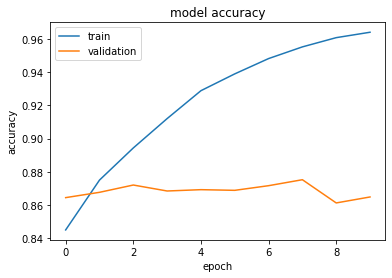

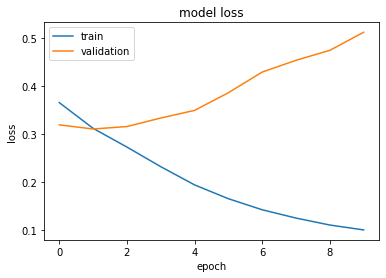

In [65]:
# list all data in history
keys = history.history.keys()
# summarize history for accuracy
plt.plot(history.history["accuracy"])
if "val_accuracy" in keys:
    plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["loss"])
if "val_loss" in keys:
    plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

Let's test our model and see how it performs:

In [66]:
testing = model.evaluate(testing_mapped_ds)

977/977 [==============================] - 7s 7ms/step - loss: 0.5748 - accuracy: 0.8503


This returns 85.63% accuracy, not state of the art, but also not bad for such a simple example.

Let's run `TensorBoard` to explore our models loading the data straight from MinIO

```bash
AWS_ACCESS_KEY_ID=minioadmin AWS_SECRET_ACCESS_KEY=minioadmin AWS_REGION=us-east-1 S3_ENDPOINT=localhost:9000 S3_USE_HTTPS=0 S3_VERIFY_SSL=0 tensorboard --logdir s3://datasets/logs
```

Then go to `http://localhost:6006` on your browser

![TensorBoard](pic4.png)

We can play with our model and see if it works

In [67]:
samples = [
    "This movie sucks",
    "This was extremely good, I loved it.",
    "great acting",
    "terrible acting",
    "pure kahoot",
    "I don't know what's the point of this movie, this movie sucks but the acting is great",
    "This is not a good movie",
]
sample_embedded = embed(samples)

In [68]:
res = model.predict(sample_embedded)
for s in range(len(samples)):
    if res[s][0] > res[s][1]:
        print(f"{samples[s]} - positive")
    else:
        print(f"{samples[s]} - negative")

This movie sucks - negative
This was extremely good, I loved it. - positive
great acting - negative
terrible acting - negative
pure kahoot - positive
I don't know what's the point of this movie, this movie sucks but the acting is great - negative
This is not a good movie - negative


# Serving the Model

We can explore model using `saved_model_cli` and check the types of inputs the model expects (which we already know from the design) but it's a decent way to see if our model is ready for TensorFlow serve

In [69]:
!export AWS_ACCESS_KEY_ID={minio_access_key}
!export AWS_SECRET_ACCESS_KEY={minio_secret_key}
!export AWS_REGION="us-east-1"
!export S3_ENDPOINT={minio_address}
!export S3_USE_HTTPS="0"
!export S3_VERIFY_SSL="0"

!saved_model_cli show --dir s3://{datasets_bucket}/imdb_sentiment_analysis --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dense_3_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1, 512)
        name: serving_default_dense_3_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_5'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1, 2)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name: '_

To test the model during this "development" stage, we are going to use the `tensorflow/serving` container image to keep things simple. So let's fireup our container and have it pull the model from MinIO. By default TensorFlow Serve exposes a `gRPC` interface on port `8500` but for the sake of example we will be using the REST endpoint by passing `--rest_api_port=8501` so that we can play with the server from this notebook or using curl

In [70]:
!docker run -p 8500:8500 \
  -p 8501:8501 \
  --name my-model-served \
  -it \
  --detach \
  -e  AWS_ACCESS_KEY_ID="minioadmin" \
  -e  AWS_SECRET_ACCESS_KEY="minioadmin" \
  -e  AWS_REGION="us-east-1" \
  -e  S3_ENDPOINT="host.docker.internal:9000" \
  -e  S3_USE_HTTPS="0" \
  -e  S3_VERIFY_SSL="0" \
  --add-host=host.docker.internal:host-gateway \
  --entrypoint=tensorflow_model_server \
  tensorflow/serving \
  --enable_batching \
  --port=8500 \
  --rest_api_port=8501 \
  --model_name=sentiment-analysis \
  --model_base_path="s3://datasets/imdb_sentiment_analysis"

docker: Error response from daemon: Conflict. The container name "/my-model-served" is already in use by container "cb32c96197049924dcb1fddd8492bc76b30a4b2a7b388eb629417fbbacc34b61". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


Now let's play with the tensorflow model serve server (had to go for it).


In [71]:
import requests
import json

In [72]:
x = requests.get('http://localhost:8501/v1/models/sentiment-analysis')
print(x.status_code)
print(json.dumps(json.loads(x.content),indent=2))

200
{
  "model_version_status": [
    {
      "version": "1",
      "state": "AVAILABLE",
      "status": {
        "error_code": "OK",
        "error_message": ""
      }
    }
  ]
}


Looks our model is ready to `serve` hahaha, let's encode one of our senteces as a `(-1, 1, 512)` input and beam it to our server

In [73]:
encoded_sentence = embed(["I loved the movie",
                          "I hated the movie"]),
for inp in encoded_sentence[0].numpy():
    print(len(inp))

512
512


In [74]:
samples = [
    "This movie sucks",
    "This was extremely good, I loved it.",
    "great acting",
    "terrible acting",
    "pure kahoot",
    "I don't know what's the point of this movie, this movie sucks but the acting is great",
    "This is not a good movie",
]

encoded_sentence = embed(samples),
input_sentences = []
for inp in encoded_sentence[0].numpy():
    input_sentences.append(inp.tolist())
input = {
    "inputs":[
        input_sentences
    ]
}

x = requests.post('http://localhost:8501/v1/models/sentiment-analysis:predict',json.dumps(input))
print(x.status_code)
if x.status_code >= 400:
    print(x.content)
else:
    print(json.dumps(json.loads(x.content),indent=2))
    print("---Pretty Printing Results---")
    serve_response = json.loads(x.content)
    for i in range(len(serve_response['outputs'][0])):
        if serve_response['outputs'][0][i][0] > serve_response['outputs'][0][i][1]:
            print(f"{samples[i]} - positive")
        else:
            print(f"{samples[i]} - negative")

200
{
  "outputs": [
    [
      [
        3.95081809e-18,
        1.0
      ],
      [
        0.999999166,
        8.59868067e-07
      ],
      [
        1.2191056e-07,
        0.999999881
      ],
      [
        4.76984378e-14,
        1.0
      ],
      [
        1.0,
        1.87321048e-10
      ],
      [
        5.32020174e-14,
        1.0
      ],
      [
        3.15164338e-27,
        1.0
      ]
    ]
  ]
}
---Pretty Printing Results---
This movie sucks - negative
This was extremely good, I loved it. - positive
great acting - negative
terrible acting - negative
pure kahoot - positive
I don't know what's the point of this movie, this movie sucks but the acting is great - negative
This is not a good movie - negative


# Conclusion

As demonstrated, you can build large scale AI/ML pipelines that can rely entirely on MinIO. This is a function of both MinIO's performance charateristics but also its ability to seamlessly scale to Petabytes and Exabytes of data. By separating storage and compute, one can build a framework that is not dependant on local resources - allowing you to run them on a container inside Kubernetes. This adds considerable flexibility.

You can see how TensorFlow was able to load the data as it was needed and no customization was needed at all, it simply worked. Moreover this approach could be quickly extended to training by running [TensorFlow in a distributed](https://www.tensorflow.org/guide/distributed_training) manner. This ensures there is very little data to shuffle over the network between training nodes as MinIO becomes the sole source of that data.

Copyright MinIO 2020